In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import keras
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import *
import visualkeras
from numpy.random import *
from numpy import *

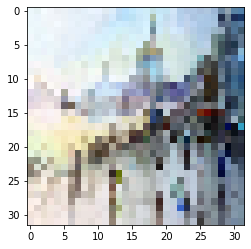

In [2]:
def list_file_in_path(img_size=(32,32)):
    img_path = './Art_Bangkok/WaterColor'
    import os
    file_list = []
    for root, dirs, files in os.walk(img_path):
        for file in files:
            tmp_file = cv2.imread(os.path.join(root, file))
            tmp_file = cv2.resize(tmp_file , img_size, interpolation=cv2.INTER_LINEAR)
            file_list.append(tmp_file)
    return file_list

all_image = list_file_in_path()
train_dataset = list_file_in_path()
train_dataset = np.array(train_dataset) / 255.0
def generate_real_samples(dataset, n_samples):
    dataset = np.array(dataset)
    ix = randint(0,  dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

x_real, y_real = generate_real_samples(train_dataset, 100)
plt.imshow(x_real[0])

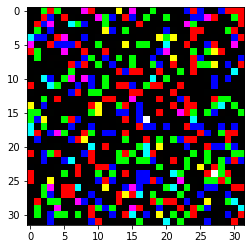

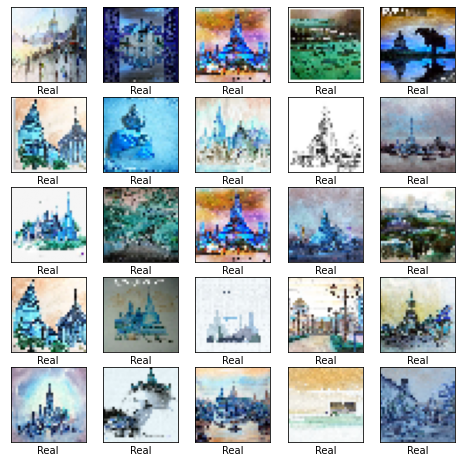

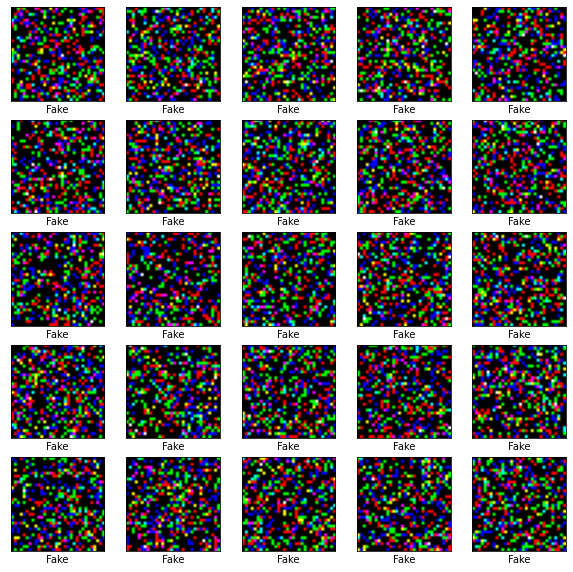

In [3]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

def test_generate_fake_samples(n_samples,target_size=(32,32)):
    hwc = (target_size[0],target_size[1],3)
    X = randn(n_samples, *hwc).astype(np.uint8)
    y = zeros((n_samples, 1))
    return X, y

x_fake, y_fake = test_generate_fake_samples(100)
plt.imshow(x_fake[0])
def show_all_image():
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_real[i], cmap=plt.cm.binary)
        plt.xlabel('Real')
    plt.show()
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_fake[i], cmap=plt.cm.binary)
        plt.xlabel('Fake')
    plt.show()

show_all_image()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 activation (Activation)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 activation_1 (Activation)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 activation_2 (Activation)   (None, 4, 4, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         2

C:\Users\SHIBASAN\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


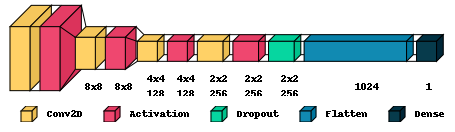

In [4]:
def define_discriminator(input_shape = (32,32,3)):
      # DEFINE MODEL
    model = Sequential()
    #normal
    model.add(Conv2D(64,(3,3),strides=(2,2),padding='same',input_shape= input_shape))
    model.add(Activation(LeakyReLU(0.2)))
    #down
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(Activation(LeakyReLU(0.2)))
    #down
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(Activation(LeakyReLU(0.2)))
    #down
    model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
    model.add(Activation(LeakyReLU(0.2)))
    #classifier
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    # COMPILE MODEL
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

d_model = define_discriminator()
d_model.summary()
visualkeras.layered_view(d_model,draw_shapes=1,legend=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 activation (Activation)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 activation_1 (Activation)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 activation_2 (Activation)   (None, 4, 4, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         2

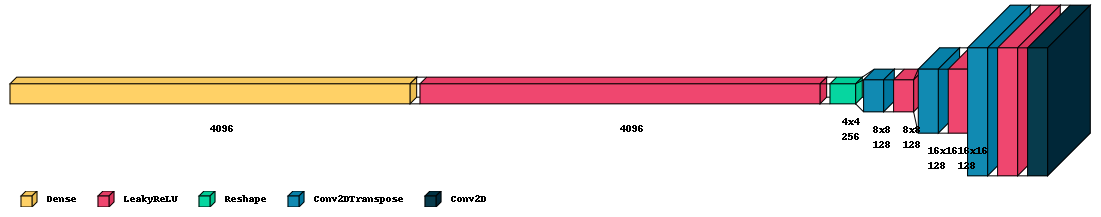

In [5]:
def train_discriminator(model,x_real,x_fake,y_real,y_fake,epochs=5,batch_size=128):
    # TRAIN MODEL
    d_loss = []
    d_acc = []
    for epoch in range(epochs):
        # TRAIN DISCRIMINATOR
        # REAL DATA
        idx = np.random.randint(0, x_real.shape[0], batch_size)
        real_images = x_real[idx]
        real_labels = y_real[idx]
        d_loss_real, d_acc_real = model.train_on_batch(real_images, real_labels)
        # FAKE DATA
        idx = np.random.randint(0, x_fake.shape[0], batch_size)
        fake_images = x_fake[idx]
        fake_labels = y_fake[idx]
        d_loss_fake, d_acc_fake = model.train_on_batch(fake_images, fake_labels)
        # AVERAGE LOSS AND ACCURACY
        d_loss.append((d_loss_real + d_loss_fake) / 2)
        d_acc.append((d_acc_real + d_acc_fake) / 2)
        print('>%d, d_loss=%.3f, d_acc=%.3f' % (epoch + 1, d_loss[-1], d_acc[-1]))
    return d_loss, d_acc

d_model.summary()
train_discriminator(d_model,x_real,x_fake,y_real,y_fake,epochs=5,batch_size=128)
# define the standalone generator model

def define_generator(latent_dim,disc_output_shape=(256,4,4)):
    model = Sequential()
    # foundation for 4x4 image
    c,w,h = disc_output_shape
    n_nodes = c*w*h
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((w, h, c)))
    # upsample
    model.add(Conv2DTranspose(128, (w, h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample
    model.add(Conv2DTranspose(128, (w, h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample
    model.add(Conv2DTranspose(128, (w, h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

g_model = define_generator(latent_dim=100)
g_model.summary()
visualkeras.layered_view(g_model,draw_shapes=1,legend=True)

In [10]:
def define_gan(g_model, d_model, image_shape=(32,32,3)):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
# generate points in latent space as input for the generator

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def train(g_model, d_model, gan_model, dataset, latent_dim,n_batch=128,n_epochs=50):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    d_loss1 = 0
    d_loss2 = 0
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
        # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this epoch
        print('>%d, d=%.3f, g=%.3f' % (i+1, d_loss1, d_loss2))
        # evaluate the model performance, sometimes
        if (i+1) % 1000 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    print(X_real.shape, y_real.shape)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save the generator model tile file
    filename = './Saved_model/generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential (Sequential)     (None, 1)                 519425    
                                                                 
Total params: 1,985,540
Trainable params: 1,466,115
Non-trainable params: 519,425
_________________________________________________________________


In [11]:
train(g_model, d_model, gan_model, train_dataset, latent_dim=100,n_epochs=3000)

>1, d=0.677, g=0.757
>2, d=0.675, g=0.751
>3, d=0.676, g=0.750
>4, d=0.674, g=0.744
>5, d=0.676, g=0.746
>6, d=0.674, g=0.741
>7, d=0.674, g=0.737
>8, d=0.673, g=0.735
>9, d=0.677, g=0.730
>10, d=0.674, g=0.731
>11, d=0.672, g=0.725
>12, d=0.671, g=0.726
>13, d=0.673, g=0.726
>14, d=0.670, g=0.725
>15, d=0.676, g=0.725
>16, d=0.676, g=0.718
>17, d=0.676, g=0.718
>18, d=0.682, g=0.713
>19, d=0.685, g=0.708
>20, d=0.688, g=0.702
>21, d=0.693, g=0.698
>22, d=0.693, g=0.698
>23, d=0.694, g=0.691
>24, d=0.692, g=0.687
>25, d=0.695, g=0.681
>26, d=0.698, g=0.682
>27, d=0.698, g=0.680
>28, d=0.698, g=0.681
>29, d=0.695, g=0.682
>30, d=0.697, g=0.678
>31, d=0.695, g=0.682
>32, d=0.695, g=0.682
>33, d=0.700, g=0.674
>34, d=0.699, g=0.674
>35, d=0.707, g=0.671
>36, d=0.715, g=0.659
>37, d=0.715, g=0.653
>38, d=0.724, g=0.651
>39, d=0.726, g=0.660
>40, d=0.723, g=0.666
>41, d=0.719, g=0.677
>42, d=0.712, g=0.688
>43, d=0.703, g=0.695
>44, d=0.694, g=0.699
>45, d=0.687, g=0.702
>46, d=0.676, g=0.7

In [12]:
X = g_model.predict(generate_latent_points(100,1))

In [13]:
def plot_all_image():
    plt.figure(figsize=(10,10))
    for i in range(25):
        X = g_model.predict(generate_latent_points(100,1))
        plt.subplot(5,5,i+1)
        plt.imshow(X[0,:,:,:])
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

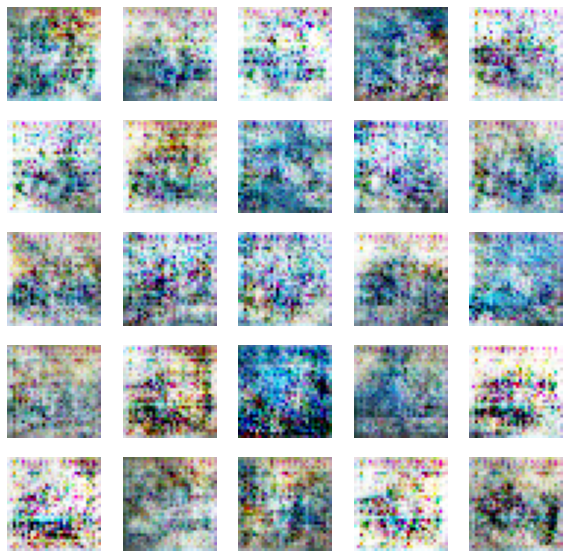

In [19]:
plot_all_image()